In [ ]:
import pandas as pd
import numpy as np
import re
import string
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import keras

In [2]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    #MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    #MAX_LEN = 75
    EMBEDDING = 20

In [3]:
df = pd.read_excel (r'gujrati_modelDataset.xlsx', sheet_name='Sheet1')
df.head(5)

,sent_index,word,tag
0,0,ભારતીય,B-LOC
1,0,ગણરાજ્ય,O
2,0,એ,O
3,0,અનેક,O
4,0,સાંસ્કૃતિક,O


In [4]:
data = df.copy()

In [5]:
words = list(set(data["word"].values))
#words.append("ENDPAD")
n_words = len(words); 
n_words

6566

In [6]:
tags = list(set(data["tag"].values))
n_tags = len(tags); n_tags

7

In [7]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sent_index").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
#         try:
        s = self.grouped[int("{}".format(self.n_sent))]
        self.n_sent += 1
        return s
#         except:
#             return None

In [8]:
#data[data['sent_index']==1]

In [9]:
getter = SentenceGetter(data)

In [10]:
print(getter.get_next())

[('ભારતીય', 'B-LOC'), ('ગણરાજ્ય', 'O'), ('એ', 'O'), ('અનેક', 'O'), ('સાંસ્કૃતિક', 'O'), ('વિવિધતાઓ', 'O'), ('ધરાવતો', 'O'), ('દક્ષિણ', 'O'), ('એશિયા', 'B-LOC'), ('સ્થિત', 'O'), ('દુનિયાનો', 'O'), ('સૌથી', 'O'), ('મોટું', 'O'), ('લોકશાહી', 'O'), ('તંત્ર', 'O'), ('ધરાવતો', 'O'), ('દેશ', 'O'), ('છે', 'O')]


In [11]:
sentences = getter.sentences

In [13]:
MAX_LEN  = max([len(s) for s in sentences])
print ('Maximum sequence length:', MAX_LEN)

Maximum sequence length: 82


In [14]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [15]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=MAX_LEN , sequences=X, padding="post", value=n_words-1)
X

array([[5195, 3523, 2748, ..., 6565, 6565, 6565],
       [ 479, 4804, 4410, ..., 6565, 6565, 6565],
       [ 479, 4804, 4410, ..., 6565, 6565, 6565],
       ...,
       [3864, 1126, 4447, ..., 6565, 6565, 6565],
       [6102, 2760, 1419, ..., 6565, 6565, 6565],
       [5218, 6500, 1692, ..., 6565, 6565, 6565]])

In [16]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=MAX_LEN , sequences=y, padding="post", value=tag2idx["O"])


In [17]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

# Setup the CRF-LSTM

In [18]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
import keras as k

In [20]:

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 82)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 82, 20)            131360    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 82, 100)           28400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 82, 50)            5050      
_________________________________________________________________
crf_2 (CRF)                  (None, 82, 7)             420       
Total params: 165,230
Trainable params: 165,230
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=0.1, verbose=2)


Train on 2785 samples, validate on 310 samples
Epoch 1/5
 - 16s - loss: 0.2676 - crf_viterbi_accuracy: 0.9171 - val_loss: 0.1361 - val_crf_viterbi_accuracy: 0.9543
Epoch 2/5
 - 13s - loss: 0.1225 - crf_viterbi_accuracy: 0.9595 - val_loss: 0.0804 - val_crf_viterbi_accuracy: 0.9760
Epoch 3/5
 - 12s - loss: 0.0683 - crf_viterbi_accuracy: 0.9802 - val_loss: 0.0521 - val_crf_viterbi_accuracy: 0.9848
Epoch 4/5
 - 18s - loss: 0.0420 - crf_viterbi_accuracy: 0.9861 - val_loss: 0.0374 - val_crf_viterbi_accuracy: 0.9870
Epoch 5/5
 - 14s - loss: 0.0288 - crf_viterbi_accuracy: 0.9898 - val_loss: 0.0321 - val_crf_viterbi_accuracy: 0.9904


In [26]:
model.save('bi_lstm_crf_gujarati.h5')

In [28]:
i = 3
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_te[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))

Word           (True ): Pred
Maharishi     : B-LOC
મીમાંસા       : I-LOC
શેઢી          : B-LOC
રમતમાંથી      : O
પુરુષોમાંના   : B-LOC
ફેલાયેલું     : O
આયર્લેન્ડ     : O
great         : O
ફેલાયેલું     : O
આયર્લેન્ડ     : O
લોમ્બાર્ડી    : O
મડાગાસ્કરનો   : O
બહારની        : O
આપે           : O
દેશભક્તિ      : O
અંતર          : O
જ્યોતિર્લીંગો : O
ગણગણતો        : O
વાંસવાડા      : O
સેમિટિક       : O
પાછળ          : B-LOC
સમય           : I-LOC
આયર્લેન્ડ     : O
કાયમીપણે      : O
ટાઇગર         : O
સાહિત્ય       : O
મુળી          : O
સપ્ટેમ્બરનો   : O
કિર્સ્ટન      : O
મીમાંસા       : I-LOC
કર્નલ         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત         : O
શાસિત  

In [29]:

from tqdm import tqdm


In [30]:
pred = []
for i in tqdm(range(len(y_te))):
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    pred.append(p)

100%|██████████| 344/344 [00:05<00:00, 61.65it/s]


In [31]:
pred_temp = [x[0] for x in pred]

y_temp = []

for i in range(len(y_te)):
    y_temp.append(np.array([np.where(y_te[i][j]==1)[0][0] for j in range(len(y_te[i]))]))

In [32]:
actual = y_temp[0]
for i in range(1, len(y_temp)):
    actual = np.concatenate((actual, y_temp[i]), axis=None)

In [33]:
predicted = pred_temp[0]
for i in range(1, len(pred_temp)):
    predicted = np.concatenate((predicted, pred_temp[i]), axis=None)

In [34]:
import scikitplot as skplt
from sklearn.metrics import classification_report

C:\Users\sagun\anaconda3\envs\Capstone1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           O       1.00      1.00      1.00     26797
       B-ORG       0.40      0.81      0.53        89
       B-PER       0.30      0.40      0.34        65
       I-LOC       0.99      0.94      0.97       424
       I-PER       0.00      0.00      0.00        82
       I-ORG       0.55      0.27      0.36        82
       B-LOC       0.94      0.92      0.93       669

    accuracy                           0.99     28208
   macro avg       0.60      0.62      0.59     28208
weighted avg       0.99      0.99      0.99     28208



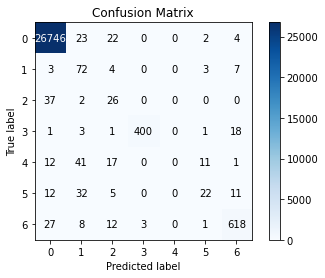

In [35]:
skplt.metrics.plot_confusion_matrix(actual, predicted)
print(classification_report(actual, predicted, target_names=tags))